<a href="https://colab.research.google.com/github/aryachandrak/Machine-Learning-2024-Ganjil/blob/main/Jobsheet4/Praktikum5_Klasifikasi_Citra_Siang_dan_Malam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Langkah 0 - Import Library

In [2]:
# Import Required Libraries
from pathlib import Path
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import cv2
import random
import numpy as np
import pandas as pd

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Lakukan ekstraksi data gambar, kemudian definisikan lokasi gambar. Pada contoh ini, folder gambar berlokasi sama dengan lokasi file python

In [4]:
# Image directories
train_dir = "/content/drive/MyDrive/images/training/"
test_dir = "/content/drive/MyDrive/images/test/"

#Langkah 1 - Load Data dan Visualisasikan

Buatlah fungsi untuk membuat daftar seluruh path dari gambar.

In [5]:
def load_dataset(img_dir): # fungsi bernama load_dataset yang menerima satu argumen img_dir
    p = Path(img_dir) # mengubah objek img_dir menjadi path
    dirs = p.glob('*') # glob digunakan untuk mencari semua direktori didalam img_dir, ('*') berarti mengambil semua folder dari direktori tersebut

    img_list = [] # membuat list kosong yang nantinya akan digunakan untuk menyimpan gambar dan label terkait

    for dir in dirs: # membuat perulangan untuk setiap direktori dir yang ditemukan dalam img_dir
        label = str(dir).split('/')[-1] # mengambil nama folder/direktori terakhir dari path. mengonversi objek dir menjadi string, membaginya berdasarkan /, dan mengambil elemen terakhir (nama direktori) sebagai label.
        for file in dir.glob('*.jpg'): # memulai loop lagi mencari file dengan ekstensi .jpg didalam direktori dir
            img = mpimg.imread(file)  # membaca file gambar

            if not img is None: # memastikan img tidak none
                img_list.append((img, label)) # menambahkan tuple(img, label) kedalam img_list. img adalah gambar dan label adalah nama direktori

    return img_list # nilai kembalian adalah img_list

Load gambar training

In [6]:
# Load training data
train_img = load_dataset(train_dir) # memanggil function load_dataset

Lakukan pengecekan pada salah satu data pada list. List harus berisi tuple dengan dua data, yaitu data gambar dan label dari gambar.

In [7]:
# Check the first data
# It should be a tuple consist of arrays of image and image labels
train_img[0] # cek indeks dari tuple ke 0 outputnya akan berupa image dan label

(array([[[78, 78, 76],
         [75, 76, 71],
         [72, 73, 68],
         ...,
         [61, 59, 60],
         [71, 69, 70],
         [77, 75, 76]],
 
        [[77, 77, 75],
         [74, 75, 70],
         [71, 72, 66],
         ...,
         [49, 47, 48],
         [53, 51, 52],
         [55, 53, 54]],
 
        [[75, 76, 71],
         [73, 74, 69],
         [69, 70, 64],
         ...,
         [41, 39, 40],
         [39, 37, 38],
         [38, 36, 37]],
 
        ...,
 
        [[88, 72, 59],
         [86, 72, 59],
         [88, 72, 59],
         ...,
         [67, 54, 48],
         [67, 54, 48],
         [67, 54, 48]],
 
        [[87, 73, 62],
         [87, 75, 63],
         [88, 74, 63],
         ...,
         [67, 54, 48],
         [67, 54, 48],
         [67, 54, 48]],
 
        [[88, 76, 64],
         [88, 76, 64],
         [89, 77, 65],
         ...,
         [67, 54, 48],
         [67, 54, 48],
         [67, 54, 48]]], dtype=uint8),
 'night')

Cek ukuran gambar secara acak

In [8]:
# Random size checking
pick_random = np.random.randint(0, len(train_img))
# len(train_img) digunakan untuk mengecek length variabel train_img
# randint(min, max), 0 adalah batas bawah dan len(train_img) adalah batas atas dari bilangan acak yang akan dihasilkan oleh fungsi randint

# Check img size
print(f'Image {pick_random}') # mengambil gambar random
print(train_img[pick_random][0].shape) # mengambil baris tuple random lalu indeks [0] untuk mengambil data gambar dan .shape untuk mengetahui ukuran gambar

Image 87
(700, 1280, 3)


Tampilkan gambar untuk inspeksi secara visual. Buatlah fungsi untuk membantu memvisualkan gambar

In [9]:
# Function to Visualize
def random_img_viz(img_list): # membuat function dengan nama random_img_viz yang menerima satu argumen yaitu img_list
    rand_num = np.random.randint(0, len(img_list)) # generate nilai random menggunakan random.randint(min, max)

    img = img_list[rand_num][0] # mengambil indeks tuple random lalu indeks [0] untuk mengambil data gambar
    label = img_list[rand_num][1] # mengambil indeks tuple random lalu indeks [1] untuk mengambil label gambar
    label_str = 'day' if label == 1 else 'night' # label sudah bernilai day atau night jadi kode ini tidak relevan

    plt.imshow(img) # menampilkan gambar
    print(f'Shape\t: {img.shape}') # menampilkan ukuran gambar
    print(f'Label\t: {label}') # menampilkan label dari gambar

Lakukan visualisasi gambar secara acak

Shape	: (458, 800, 3)
Label	: day


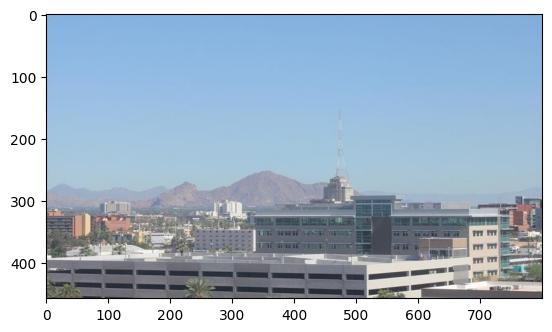

In [10]:
random_img_viz(train_img) # memanggil fungsi random_img_viz dengan parameter train_img

#Langkah 3 - Pra Pengolahan Data

Pada tahap ini, kita akan melakukan dua proses utama, yaitu standardisasi ukuran gambar, dan encoding label gambar.

Bualah fungsi berikut untuk menstandarkan ukuran gambar

In [11]:
def standarized_input(image): # membuat fungsi dengan nama standarized_input yang menerima argumen image
    # resize to w: 1100, h:600
    std_img = cv2.resize(image, (1100,600))

    return std_img # mengembalikan gambar yang telah distandarisasi

Selanjutnya, buatlah fungsi untuk kebutuhan encoding label

In [12]:
def label_encoder(label): # membuat fungsi dengan nama label_encoder yang menerima input label
    # Encode the label
    # day as 1; night as 0
    num_val = 0 # nilai num_val default adalah 0

    if(label == 'day'): # nilai num_val 1 jika label day
        num_val = 1

    return num_val

Terakhir, buatlah fungsi untuk melakukan kedua hal tersebut secara sekaligus untuk semua gambar dalam list.

In [13]:
def preprocess(img_list): # membuat fungsi dengan nama preprocess yang menerima input img_list
    std_img_list = [] # membuat list kosong yang nantinya akan digunakan untuk menyimpan gambar yang telah distandarisasi

    for item in img_list:
        image = item[0]
        label = item[1]

        # Standarized the image
        std_img = standarized_input(image)

        # Create the label
        img_label = label_encoder(label)

        std_img_list.append((std_img, img_label)) # menambahkan tupple (std_img, img_label) ke dalam std_img_list

    return std_img_list

Lakukan pra pengolahan data pada data training.

In [14]:
train_std_img_list = preprocess(train_img)

Lakukan pengecekan ukuran gambar secara acak

In [19]:
# Random size checking
pick_random = np.random.randint(0, len(train_std_img_list))

# Check img size
print(f'Image {pick_random}')
print(f'Label: {train_std_img_list[pick_random][1]}') #cek label apakah sudah berhasil diencoding
print(train_std_img_list[pick_random][0].shape) #cek gambar apakah ukurannya sudah berhasil distandarisasi

Image 25
Label: 0
(600, 1100, 3)


#Langkah 4 - Ekstraksi Fitur

Selanjutnya, untuk dapat membadakan antara label satu dengan label yang lain, kita memerlukan sebuah fitur. Fitur adalah penciri dari sebuah data yang dapat digunakan untuk membendakan data satu dengan yang lain. Pada percobaan kali ini, kita akan menggunakan fitur yang sederhana yaitu nilai rata-rata dari tingkat kecerahan gambar (average brightness). Namun sebelum dapat melakukan hal tersebut, kita akan mengubah ruang warna (colorspace) dari RGB menjadi HSV (Hue, Saturation, Value). Hal ini dikarenakan, tingkat kecerahan (brightness) lebih mudah didapatkan dari HSV berdasarkan nilai Valuenya.

Buatlah fungsi berikut untuk mendapatkan nilai rata-rata tingkat kecerahan

In [20]:
# Get feature based on average brightness using HSV colorspace
def avg_brightness(image):
    # Convert image to HSV
    img_hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)

    # Calculate the avg of brightness
    sum_brightness = np.sum(img_hsv[:,:,2]) # take the 3rb value which is the V channel
    area = image.shape[0] * image.shape[1] # kalikan heigh yaitu shape[0] dan width yaitu shape[1]
    avg = sum_brightness / area

    return avg

Lakukan pengecekan pada gambar secara acak. INGAT! Gunakan gambar yang telah melalui proses pra pengolahan data!

Image 63
Label: 0
Avg Brighness: 25.8626


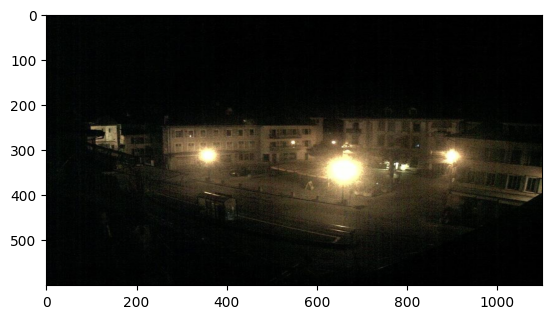

In [21]:
# Check on random image
rand_img = np.random.randint(0, len(train_std_img_list)) # mencari nilai random

feature_img = train_std_img_list[rand_img][0] # mengambil gambar random

avg_img = avg_brightness(feature_img) # menjalankan fungsi avg_brightness menggunakan gambar yang diambil random

print(f'Image {rand_img}') # menampilkan gambar yang diambil random
print(f'Label: {train_std_img_list[rand_img][1]}') # menampilkan label dari gambar yang diambil random
print(f'Avg Brighness: {avg_img:.4f}') # menampilkan avg_brightness dari gambar yang diambil random
plt.imshow(feature_img)

#Langkah 5 - Klasifikasi dengan Metode Threshold

Pada tahap ini, kita akan melakukan proses klasifikasi sederhana dengan menggunakan nilai ambang batas (threshold) dari nilai rata-rata kecerahan yang kita tentukan sendiri.

Buatlah fungsi berikut,

In [22]:
def predict_label(img, threshold):
    # Computer average brightness
    avg = avg_brightness(img)
    pred = 0 #nilai prediksi default

    # Predict the label based on user defined threshold
    if avg > threshold: #jika nilai avg lebih tinggi dari threshold maka pred=1
        pred = 1

    return pred

Lakukan pengecekan prediksi secara acak pada data training

Image 122
Actual label: 1
Predicted label: 1


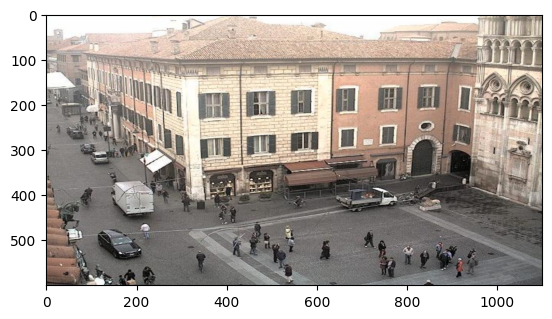

In [23]:
# Test the classifier on train data
rand_img = np.random.randint(0, len(train_std_img_list))

pred = predict_label(train_std_img_list[rand_img][0], threshold=120)

# Evaluate
print(f'Image {rand_img}') # Print random image
print(f'Actual label: {train_std_img_list[rand_img][1]}') # Print actual label
print(f'Predicted label: {pred}') # Print predicted label
plt.imshow(train_std_img_list[rand_img][0]) # show image

#Langkah 6 - Evaluasi (Manual)

Selanjutnya kita akan membuat fungsi evaluasi model sederhana, yaitu dengan membandingkan label yang diprediksi benar dengan seluruh data. Ingat kembali konsep confussion matrix.

Buatlah fungsi berikut,

In [24]:
def evaluate(img_list, threshold):
    miss_labels = []

    for file in img_list:
        # Get the ground truth / correct label
        img = file[0]
        label = file[1]

        # Get prediction
        pred_label = predict_label(img, threshold)

        # Compare ground truth and pred
        if pred_label != label:
            miss_labels.append((img, pred_label, label))

    total_img = len(img_list)
    corr_pred = total_img - len(miss_labels)
    accuracy = corr_pred / total_img

    print(f'Accuracy: {accuracy:.4f}')

Lakukan evaluasi pada data training dengan nilai ambang batas 120

In [30]:
# Evaluate on train data
evaluate(train_std_img_list, threshold=100)

Accuracy: 0.9042


Selanjutnya, kita akan melakukan evaluasi pada data testing. Namun sebelumnya, data testing harus diperlakukan sama dengan data training dalam konteks pra progolahan data dan ekstraksi fitur.

In [32]:
# Evaluate on test data

# Load test data
test_img = load_dataset(test_dir)

# Preprocess
test_std_img_list = preprocess(test_img)

# Predict
evaluate(test_std_img_list, threshold=100)

Accuracy: 0.9250
